# 5.14 应用：人脸识别管道

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

## 5.14.1 HOG特征（方向梯度直方图，Histogram of Oriented Gradients）

In [5]:
from skimage import data, color, feature

In [6]:
import skimage.data

In [7]:
image = color.rgb2gray(data.chelsea())

In [13]:
hog_vec, hog_vis = feature.hog(image, visualize=True)

Text(0.5,1,'visualization of HOG features')

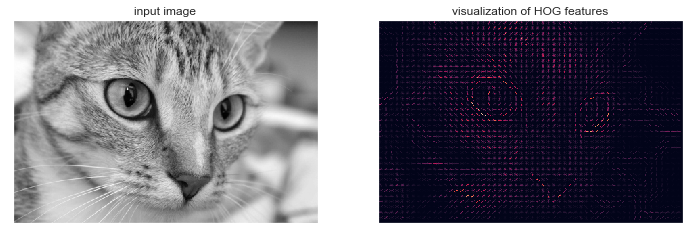

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features')

## 5.14.2 HOG实战：简单人脸识别器

（1）获取一组正训练样本

In [15]:
from sklearn.datasets import fetch_lfw_people

In [16]:
faces = fetch_lfw_people()

In [17]:
positive_pathes = faces.images

In [18]:
positive_pathes.shape

(13233, 62, 47)

（2）获取一组负训练样本

In [19]:
from skimage import data, transform

In [20]:
imgs_to_use = ['camera', 'text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']

In [21]:
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

In [22]:
from sklearn.feature_extraction.image import PatchExtractor

In [23]:
def extract_patches(img, N, scale=1.0, patch_size=positive_pathes[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])
    
    return patches

In [28]:
negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])

In [29]:
negative_patches.shape

(30000, 62, 47)

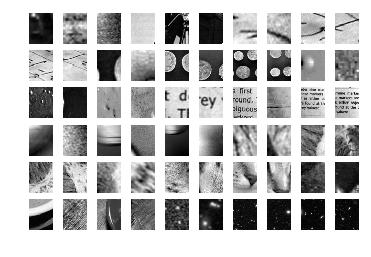

In [30]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

没有人脸的负图像训练集

（3）组合数据集并提取HOG特征。

In [31]:
from itertools import chain

In [32]:
x_train = np.array([feature.hog(im) for im in chain(positive_pathes, negative_patches)])

In [33]:
y_train = np.zeros(x_train.shape[0])

In [34]:
y_train[:positive_pathes.shape[0]] = 1

In [35]:
y_train

array([1., 1., 1., ..., 0., 0., 0.])

In [36]:
x_train.shape

(43233, 1215)

（4）训练一个支持向量机

首先，用简答的高斯朴素贝叶斯分类器算一个初始解

In [37]:
from sklearn.naive_bayes import GaussianNB

In [38]:
from sklearn.model_selection import cross_val_score

In [39]:
cross_val_score(GaussianNB(), x_train, y_train)

d:\python35\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.95399348, 0.97377004, 0.97522726])

再用支持向量机分类，用网格搜索获取最优边界软化参数C

In [40]:
from sklearn.svm import LinearSVC

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})

In [43]:
grid.fit(x_train, y_train)

d:\python35\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
d:\python35\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\python35\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\python35\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\python35\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarni

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None, param_grid={'C': [1.0, 2.0, 4.0, 8.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [44]:
grid.best_score_

0.9889205005435663

In [45]:
grid.best_params_

{'C': 1.0}

In [46]:
model = grid.best_estimator_

In [47]:
model.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

（5）在新图像中寻找人脸

In [61]:
test_image = skimage.data.astronaut()

In [62]:
test_image = skimage.color.rgb2gray(test_image)

In [63]:
test_image = skimage.transform.rescale(test_image, 0.5)

d:\python35\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


In [64]:
test_image = test_image[:160, 40:180]

(-0.5, 139.5, 159.5, -0.5)

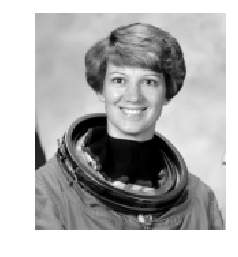

In [65]:
plt.imshow(test_image, cmap='gray')
plt.axis('off')

创建一个不断在图像中移动的窗口，然后计算每次移动位置的HOG特征

In [68]:
def sliding_window(img, patch_size=positive_pathes[0].shape, istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i: i + Ni, j: j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [69]:
indices, patches = zip(*sliding_window(test_image))

In [71]:
patches_hog = np.array([feature.hog(patch) for patch in patches])

In [72]:
patches_hog.shape

(1911, 1215)

In [73]:
labels = model.predict(patches_hog)

In [76]:
labels.sum().astype(int)

51

用矩形把收集到的信息画在图像上：

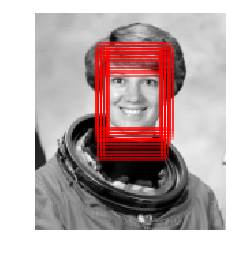

In [105]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_pathes[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, ec='red', alpha=0.3, lw=2, fc='none'))


## 5.14.3 注意事项与改进方案

In [95]:
plt.Rectangle?

Init signature: plt.Rectangle(xy, width, height, angle=0.0, **kwargs)
Docstring:     
Draw a rectangle with lower left at *xy* = (*x*, *y*) with
specified *width*, *height* and rotation *angle*.
Init docstring:
Parameters
----------
xy: length-2 tuple
    The bottom and left rectangle coordinates
width:
    Rectangle width
height:
    Rectangle height
angle: float, optional
  rotation in degrees anti-clockwise about *xy* (default is 0.0)
fill: bool, optional
    Whether to fill the rectangle (default is ``True``)

Notes
-----
Valid kwargs are:
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array 
  alpha: float or None 
  animated: bool 
  antialiased or aa: bool or None 
  capstyle: ['butt' | 'round' | 'projecting'] 
  clip_box: a `.Bbox` instance 
  clip_on: bool 
  clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None] 
  color: matplotlib color spec
  contains: a callable function 
  edgecolor or ec: mpl

# 5.15 机器学习参考资料